# Laboratorio 2: Bases de Datos Vectoriales

En este ejercicio explorarás cómo aprovechar modelos de embedding para transformar datos textuales en representaciones vectoriales, almacenarlas en una base de datos vectorial y realizar búsquedas semánticas.

Antes de comenzar el laboratorio, debes configurar el entorno de ejecución de Colab para usar GPU en el cómputo de los embeddings locales. Para ello, ve a la sección inferior de Colab y cambia el runtime a una GPU T4:

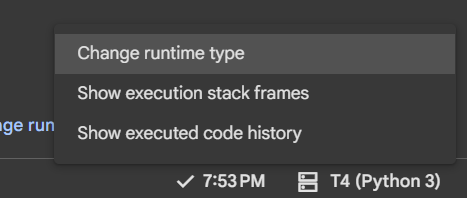

A lo largo de este laboratorio realizarás las siguientes tareas:

1. **Extracción de información de un archivo CSV**: Cargarás datos desde un archivo CSV.
2. **Creación de embeddings**: Emplearás un modelo de embedding pre-entrenado para convertir la información en vectores (embeddings).
3. **Almacenamiento en una BBDD vectorial**: Almacenarás los embeddings generados en un índice.
4. **Búsquedas semánticas**: Realizarás búsquedas semánticas en el índice para encontrar información relevante.

# Pinecone

A continuación trabajarás con Pinecone, una base de datos vectorial especializada.

## Parte 1: Extracción de información de un archivo CSV

Carga el archivo `home_depot_data.csv` (disponible en https://www.kaggle.com/datasets/thedevastator/the-home-depot-products-dataset) en un DataFrame de pandas.

In [ ]:
from google.colab import files
uploaded = files.upload()

In [ ]:
import pandas as pd

df = pd.read_csv('home_depot_data.csv')
display(df.head())

### Preparar los datos para la generación de embeddings

Selecciona las columnas de texto relevantes del DataFrame que serán utilizadas para generar los embeddings. En caso necesario, combina varias columnas (por ejemplo, nombre del producto y descripción) en un solo campo de texto.

In [ ]:
# Seleccionar columnas relevantes y combinarlas en un solo campo de texto
df['text'] = df[['title', 'description', 'price', 'currency']].fillna('').apply(
    lambda x: f"{x['title']} | {x['description']} | Price: {x['price']} {x['currency']}",
    axis=1
)

# Mostrar las primeras filas del nuevo campo
df[['title', 'description', 'price', 'currency', 'text']].head()

## Parte 2: Carga del modelo de embedding

Carga el modelo de embeddings `all-MiniLM-L6-v2` utilizando la librería `sentence-transformers`.

In [ ]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('all-MiniLM-L6-v2')

Define una función que, dado un texto, retorne su vector de embeddings en forma de lista.

In [ ]:
def get_embedding(text):
  """
  Generates an embedding vector for a given text using the loaded model.

  Args:
    text: The input text string.

  Returns:
    A list representing the embedding vector.
  """
  embedding = model.encode(text).tolist()
  return embedding

# Example usage:
example_text = "This is an example sentence."
embedding = get_embedding(example_text)
print(embedding)

## Parte 3: Creación del índice en Pinecone

En esta sección deberás establecer una conexión a tu cuenta de Pinecone utilizando tu API KEY. Para esto tendrás que crearte una cuenta en Pinecone: https://www.pinecone.io/

Inicializa Pinecone utilizando la clave de API guardada en `userdata`.

In [ ]:
# 1. Instalar la biblioteca de Pinecone
!pip install -q pinecone

In [ ]:
import os
from pinecone import Pinecone
from google.colab import userdata

# 2. Intentar obtener la clave de API desde los Secretos de Colab
try:
    PINECONE_API_KEY = userdata.get('PCONE_TOKEN')

    if PINECONE_API_KEY is None:
        raise ValueError("No se encontró la clave 'PCONE_TOKEN' en los Secretos de Colab.\n"
                         "Por favor, ve al panel 🔑 (Secretos) y añádela.")

    # 3. Inicializar el cliente de Pinecone
    pc = Pinecone(api_key=PINECONE_API_KEY)

    print("✅ ¡Conexión con Pinecone establecida exitosamente!")

except Exception as e:
    print(f"❌ Error al conectar o inicializar Pinecone: {e}")

Crea un índice en Pinecone con la dimensión correspondiente al modelo y con la métrica `cosine`.

In [ ]:
# Importamos la clase ServerlessSpec, que es la requerida para el plan gratuito actual
from pinecone import ServerlessSpec

# --- 1. Definición de parámetros ---
index_name = "home-depot-embeddings"
dimension = 384
metric = "cosine"

# --- 2. Parámetros para el plan Serverless (Gratuito) ---
cloud_provider = "aws"
region_name = "us-east-1"

try:
    # --- 3. Comprobar si el índice ya existe ---
    if index_name not in pc.list_indexes().names():

        print(f"Creando el índice Serverless '{index_name}' en {cloud_provider}:{region_name}...")

        # --- 4. Crear la especificación Serverless ---
        serverless_spec = ServerlessSpec(
            cloud=cloud_provider,    # 'aws'
            region=region_name       # 'us-east-1'
        )

        # --- 5. Crear el índice, pasando la especificación al argumento 'spec' ---
        pc.create_index(
            name=index_name,
            dimension=dimension,
            metric=metric,
            spec=serverless_spec     # <--- CLAVE: Pasamos el objeto ServerlessSpec
        )
        print(f"✅ ¡Índice Serverless '{index_name}' creado con dimensión {dimension} y métrica '{metric}'!")

    else:
        # --- 6. Si ya existe, solo informa ---
        print(f"El índice '{index_name}' ya existe. No se realizaron cambios.")

    # --- 7. Conectarse al índice y mostrar estadísticas ---
    index = pc.Index(index_name)
    print("\nEstadísticas del índice (para confirmar conexión):")
    print(index.describe_index_stats())

except Exception as e:
    print(f"❌ Ocurrió un error: {e}")

## Parte 4: Carga del índice

Implementa el código necesario para recorrer los datos del DataFrame, generar los embeddings correspondientes y realizar la inserción de la información en el índice creado previamente. Debes utilizar un esquema de procesamiento por lotes para optimizar la carga.

In [ ]:
import pandas as pd
from tqdm.auto import tqdm # Importamos tqdm para mostrar una barra de progreso

# --- 1. Configuración de la Carga por Lotes ---
BATCH_SIZE = 100
index_name = "home-depot-embeddings" # Nombre del índice
# Asumimos que 'index' ya está definido (ej: index = pc.Index(index_name))

# --- 2. Preparación de los datos ---
# 2.1 Generamos una columna de IDs única (basada en el índice del DataFrame)
if 'id' not in df.columns:
    df['id'] = df.index.astype(str)

# 2.2 Extraemos las columnas necesarias
texts = df['text'].tolist()
ids = df['id'].tolist()

print(f"Total de registros a procesar: {len(df)}")

# --- 3. Proceso de Inserción por Lotes ---
# Inicializamos la barra de progreso de tqdm
for i in tqdm(range(0, len(df), BATCH_SIZE)):
    # Definir el lote actual
    i_end = min(i + BATCH_SIZE, len(df))
    batch_df = df.iloc[i:i_end] # Usamos el sub-DataFrame para acceder a todas las columnas

    batch_ids = batch_df['id'].tolist()
    batch_texts = batch_df['text'].tolist()

    # --- A. Generar Embeddings ---
    # Generación eficiente de embeddings para todo el lote
    embeddings = model.encode(batch_texts).tolist()

    # --- B. Formatear para Pinecone (ID, Vector, Metadata) ---
    vectors_to_upload = []

    # Iteramos sobre las filas del lote
    for idx, row in batch_df.iterrows():
        # Capturamos la metadata relevante del DataFrame
        metadata = {
            "title": row['title'],
            "description": row['description'],
            "price": row['price'],
            "currency": row['currency'],
            "combined_text": row['text'] # El texto combinado es útil para depuración
        }

        # El formato es (id, vector_lista, metadata_diccionario)
        vectors_to_upload.append((
            row['id'],
            embeddings[idx - i], # Usamos el índice relativo al lote para obtener el embedding
            metadata
        ))

    # --- C. Subir el Lote a Pinecone ---
    try:
        index.upsert(vectors=vectors_to_upload)
    except Exception as e:
        print(f"Error al subir el lote {i} a {i_end}: {e}")

print("\n✅ Proceso de carga de datos finalizado.")


### Verificación de datos en el índice

Verifica las estadísticas del índice para asegurarte de que los datos se hayan cargado correctamente.

In [ ]:
import time

print("\n--- Verificación del Índice ---")
print(index.describe_index_stats())

### Búsqueda semántica

Realiza consultas al índice utilizando consultas del estilo `"best tool for repairing walls"` y muestra los resultados obtenidos.

In [ ]:
# Asumimos que 'model' (SentenceTransformer) e 'index' (Pinecone Index) están definidos.

# --- 1. Definición de la Consulta ---
query_text = "best tool for repairing walls"
top_k_results = 5 # Cuántos resultados más similares queremos ver

print(f"Búsqueda Semántica para: '{query_text}'")
print("-" * 50)

# --- 2. Generar el Vector de Consulta ---
# Usamos el mismo modelo para generar el embedding de la pregunta
query_vector = model.encode(query_text).tolist()

# --- 3. Consultar a Pinecone ---
# Usamos el método index.query()
results = index.query(
    vector=query_vector,
    top_k=top_k_results,
    include_metadata=True # Esto es clave para obtener la información original
)

# --- 4. Mostrar los Resultados ---
if results.matches:
    print(f"Se encontraron {len(results.matches)} resultados:")

    # Recorremos cada resultado encontrado por Pinecone
    for i, match in enumerate(results.matches):
        score = match.score
        metadata = match.metadata

        print(f"\nResultado {i+1} (Score: {score:.4f}):")
        print(f"  Título: {metadata.get('title', 'N/A')}")
        print(f"  Precio: {metadata.get('price', 'N/A')} {metadata.get('currency', '')}")
        print(f"  Descripción: {metadata.get('description', 'N/A')[:100]}...")
        # print(f"  Texto Completo: {metadata.get('combined_text', 'N/A')}") # Descomentar si quieres ver el texto combinado
else:
    print("No se encontraron coincidencias en el índice.")

# FAISS

Realiza una práctica de búsqueda semántica utilizando FAISS y un dataset del sitio web https://www.kaggle.com/datasets.

## Parte 5: Cargar el nuevo dataset

Carga el archivo en un DataFrame de pandas.

**Ejemplo elegido**: https://www.kaggle.com/datasets/ahmeduzaki/global-earthquake-tsunami-risk-assessment-dataset

In [ ]:
from google.colab import files
uploaded = files.upload()

In [ ]:
import pandas as pd

df = pd.read_csv('earthquake_data_tsunami.csv')
display(df.head())

### Preparar los datos para la generación de embeddings

Selecciona las columnas de texto relevantes del nuevo DataFrame que serán utilizadas para generar los embeddings. Combina las columnas necesarias en un solo campo de texto.

In [ ]:
# Preparar un único campo de texto por fila (sin depender de locales del sistema)
import pandas as pd
import numpy as np

# Asegurar tipos numéricos
cols = ['magnitude','cdi','mmi','sig','nst','dmin','gap','depth',
        'latitude','longitude','Year','Month','tsunami']
df[cols] = df[cols].apply(pd.to_numeric, errors='coerce')

# Diccionarios auxiliares
tsunami_map = {1: 'sí', 0: 'no'}
mes_es = {1:'enero',2:'febrero',3:'marzo',4:'abril',5:'mayo',6:'junio',
          7:'julio',8:'agosto',9:'septiembre',10:'octubre',11:'noviembre',12:'diciembre'}

# Nombre de mes sin usar locale (evita errores en Colab)
df['mes_nombre'] = df['Month'].round().astype('Int64').map(mes_es).fillna('desconocido')

# Construir el texto por fila, robusto a NaNs
def fila_a_texto(r):
    fmt = lambda v, ndec=0: (f"{v:.{ndec}f}" if pd.notna(v) else "NA")
    entero = lambda v: (str(int(v)) if pd.notna(v) else "NA")
    return (
        f"Terremoto de magnitud {fmt(r.magnitude,1)} "
        f"(MMI {entero(r.mmi)}, señal {entero(r.sig)}). "
        f"Profundidad {fmt(r.depth,0)} km. "
        f"Ubicación lat {fmt(r.latitude,4)}, lon {fmt(r.longitude,3)}. "
        f"Fecha {entero(r.Year)}-{entero(r.Month)} ({r.mes_nombre}). "
        f"Estaciones {entero(r.nst)}, gap {fmt(r.gap,1)}, dmin {fmt(r.dmin,3)}. "
        f"Tsunami: {tsunami_map.get(int(r.tsunami) if pd.notna(r.tsunami) else -1, 'desconocido')}."
    )

df['text_for_embedding'] = df.apply(fila_a_texto, axis=1)

# DataFrame listo para embeddings
df_embeddings = df[['text_for_embedding']].copy()
display(df_embeddings.head())


## Parte 6: Generar embeddings

Aplica la función para generar los embeddings del texto preparado en el paso anterior.

In [ ]:
from sentence_transformers import SentenceTransformer
import numpy as np

# Cargar modelo de embeddings (compacto y rápido)
model = SentenceTransformer('all-MiniLM-L6-v2')

# Convertir la columna de texto a lista
texts = df['text_for_embedding'].astype(str).tolist()

# Generar embeddings normalizados (para usar luego similitud coseno con FAISS)
embeddings = model.encode(
    texts,
    batch_size=64,
    show_progress_bar=True,
    convert_to_numpy=True,
    normalize_embeddings=True
).astype('float32')

# Mostrar forma del array resultante
print("Embeddings generados con forma:", embeddings.shape)

## Parte 7: Crear un índice FAISS

Inicializa un índice FAISS con la dimensión correcta para los embeddings generados.

In [ ]:
!pip install faiss-cpu

In [ ]:
import faiss
import numpy as np

# Obtener la dimensión de los embeddings generados
dimension = embeddings.shape[1]
print(f"Dimensión de los embeddings: {dimension}")

# Crear el índice FAISS (IndexFlatIP para similitud coseno)
index = faiss.IndexFlatIP(dimension)

print("Índice FAISS creado correctamente.")

### Agregar embeddings al índice FAISS

Agrega los embeddings generados al índice FAISS.

In [ ]:
# Agregar los embeddings generados al índice FAISS
index.add(embeddings)

# Verificar cuántos vectores contiene el índice
print(f"Embeddings agregados al índice. Total de vectores: {index.ntotal}")

### Realizar búsquedas semánticas en FAISS

Realiza consultas al índice FAISS utilizando consultas de texto y muestra los resultados obtenidos.

In [ ]:
# Realizar búsquedas semánticas en FAISS usando consultas de texto

import numpy as np
import pandas as pd

# 2) Función para buscar en el índice FAISS
def buscar_faiss(query_text, k=5):
    """
    Genera el embedding de la consulta y busca los k más similares en el índice FAISS.
    Retorna un DataFrame con resultados y los puntajes de similitud.
    """
    # Generar embedding normalizado de la consulta (para similitud coseno con IndexFlatIP)
    q_vec = model.encode([query_text], normalize_embeddings=True, convert_to_numpy=True).astype('float32')

    # Consultar FAISS
    scores, idxs = index.search(q_vec, k)  # scores = producto interno (≈ coseno)
    idxs = idxs[0]
    scores = scores[0]

    # Armar tabla de resultados (join con df original)
    res = df.iloc[idxs].copy()
    res = res.assign(
        rank=np.arange(1, len(idxs)+1),
        score=np.round(scores, 4)
    )[['rank','score','text_for_embedding','magnitude','Year','Month','latitude','longitude']]
    res = res.rename(columns={'text_for_embedding':'texto'})
    return res

# 3) Ejemplos de consulta (puedes cambiar 'consulta' y 'k' a gusto)
consulta = "terremoto de magnitud 7 con tsunami"
resultados = buscar_faiss(consulta, k=5)

# 4) Mostrar resultados
print(f"Consulta: {consulta}\n")
display(resultados)
